<a href="https://colab.research.google.com/github/EnergyMate/machine-learning/blob/main/notebook/EnergyMate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf

#Data Loading

In [2]:
df = pd.read_csv('/content/household_power_consumption.txt', sep=";")
print(df.info())
df.head()

/tmp/ipython-input-1795318880.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/household_power_consumption.txt', sep=";")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


#Resample Perjam

Resample tanpa aggregasi pada sub_metering

In [3]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df_agg = df.dropna(subset=['Datetime'])
df_agg.set_index('Datetime', inplace=True)

df_agg.drop(columns=['Date', 'Time'], inplace=True)
df_agg['hour'] = df_agg.index.hour
df_agg = df_agg.apply(pd.to_numeric, errors='coerce')
print(df_agg.info())
df_agg.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   hour                   int32  
dtypes: float64(7), int32(1)
memory usage: 134.6 MB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour
Datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17


In [4]:
print("Missing Values:\n", df_agg.isnull().sum())
print("\nDuplicate Rows:", df_agg.duplicated().sum())

Missing Values:
 Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
hour                         0
dtype: int64

Duplicate Rows: 52552


In [5]:
df_agg = df_agg.interpolate(method='time')
df_agg = df_agg.drop_duplicates()

print("Missing Values:\n", df_agg.isnull().sum())
print("\nDuplicate Rows:", df_agg.duplicated().sum())
print(df_agg.info())
df_agg.head()

Missing Values:
 Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
hour                     0
dtype: int64

Duplicate Rows: 0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2048662 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   hour                   int32  
dtypes: float64(7), int32(1)
memory usage: 132.9 MB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour
Datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17


# Normalisasi

In [16]:
X = df_agg[['Global_intensity','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour']]
y = df_agg['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

print(f'Total keseluruhan data: {len(X)}')
print(f'Total keseluruhan data train: {len(X_train)}')
print(f'Total keseluruhan data validation: {len(X_val)}')
print(f'Total keseluruhan data test: {len(X_test)}')

Total keseluruhan data: 2048662
Total keseluruhan data train: 1311143
Total keseluruhan data validation: 327786
Total keseluruhan data test: 409733


# LSTM Model 24 Jam Terakhir

In [17]:
# Sequences untuk multi-step forecasting
def create_multistep_sequences(X, y, seq_length=24, horizon_steps=[1, 6, 12, 24]):
    Xs, ys = [], []
    for i in range(len(X) - seq_length - max(horizon_steps)):
        Xs.append(X[i:i+seq_length])
        ys.append([y[i+seq_length+h-1, 0] for h in horizon_steps])
    return np.array(Xs), np.array(ys)

# Sequence dengan 24 jam input
seq_length = 24
horizon_steps = [1, 6, 12, 24]

X_train_seq, y_train_seq = create_multistep_sequences(X_train, y_train, seq_length, horizon_steps)
X_val_seq, y_val_seq = create_multistep_sequences(X_val, y_val, seq_length, horizon_steps)
X_test_seq, y_test_seq = create_multistep_sequences(X_test, y_test, seq_length, horizon_steps)

print(f"Train shape: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"Val shape: {X_val_seq.shape}, {y_val_seq.shape}")
print(f"Test shape: {X_test_seq.shape}, {y_test_seq.shape}")

Train shape: (1311095, 24, 5), (1311095, 4)
Val shape: (327738, 24, 5), (327738, 4)
Test shape: (409685, 24, 5), (409685, 4)


In [19]:
model_lstm = Sequential([
    LSTM(64, input_shape=(seq_length, X.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(4) # output 4 horizon (1h, 6h, 12h, 24h)
])

model_lstm.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5), loss='mse', metrics=['mae'])

# Callback
checkpoint = ModelCheckpoint("best_modelLSTM.keras", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=128,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - loss: 0.0037 - mae: 0.0357 - val_loss: 0.0025 - val_mae: 0.0279
Epoch 2/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0024 - val_mae: 0.0276
Epoch 3/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - loss: 0.0031 - mae: 0.0322 - val_loss: 0.0023 - val_mae: 0.0267
Epoch 4/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.0030 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0272
Epoch 5/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.0030 - mae: 0.0316 - val_loss: 0.0022 - val_mae: 0.0258
Epoch 6/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step - loss: 0.0029 - mae: 0.0314 - val_loss: 0.0022 - val_mae: 0.0256
Epoch 7/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - loss: 0.0029 - mae: 0.0312 - val_loss: 0.0021 - val_mae: 0.0261
Epoch 8/10
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - loss: 0.0028 - mae: 0.0305 - val_loss: 0.0021 - val_mae: 0.0252
Epoch 9/10
10243

In [24]:
def evaluate_model(name, X_seq, y_seq, scaler_y, model, horizon_steps):
    y_pred = model_lstm.predict(X_seq)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_true_rescaled = scaler_y.inverse_transform(y_seq)

    print(f"\n===== Evaluasi pada {name} set =====")
    for i, step in enumerate(horizon_steps):
        mae = mean_absolute_error(y_true_rescaled[:, i], y_pred_rescaled[:, i])
        rmse = np.sqrt(mean_squared_error(y_true_rescaled[:, i], y_pred_rescaled[:, i]))
        r2 = r2_score(y_true_rescaled[:, i], y_pred_rescaled[:, i])
        print(f"\n--- Horizon {step} jam ---")
        print(f"MAE  = {mae:.4f}")
        print(f"RMSE = {rmse:.4f}")
        print(f"R²   = {r2:.4f}")
    return y_true_rescaled, y_pred_rescaled

# === Evaluasi untuk Train, Validation, dan Test ===
y_true_train, y_pred_train = evaluate_model("Train", X_train_seq, y_train_seq, y_scaler, model_lstm, horizon_steps)
y_true_test, y_pred_test = evaluate_model("Test", X_test_seq, y_test_seq, y_scaler, model_lstm, horizon_steps)

40972/40972 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step

===== Evaluasi pada Train set =====

--- Horizon 1 jam ---
MAE  = 0.1180
RMSE = 0.2543
R²   = 0.9475

--- Horizon 6 jam ---
MAE  = 0.2545
RMSE = 0.4934
R²   = 0.8025

--- Horizon 12 jam ---
MAE  = 0.3415
RMSE = 0.6043
R²   = 0.7038

--- Horizon 24 jam ---
MAE  = 0.4434
RMSE = 0.7253
R²   = 0.5733
12803/12803 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step

===== Evaluasi pada Test set =====

--- Horizon 1 jam ---
MAE  = 0.1051
RMSE = 0.2108
R²   = 0.9424

--- Horizon 6 jam ---
MAE  = 0.2301
RMSE = 0.4193
R²   = 0.7720

--- Horizon 12 jam ---
MAE  = 0.3007
RMSE = 0.5111
R²   = 0.6612

--- Horizon 24 jam ---
MAE  = 0.3836
RMSE = 0.6109
R²   = 0.5160


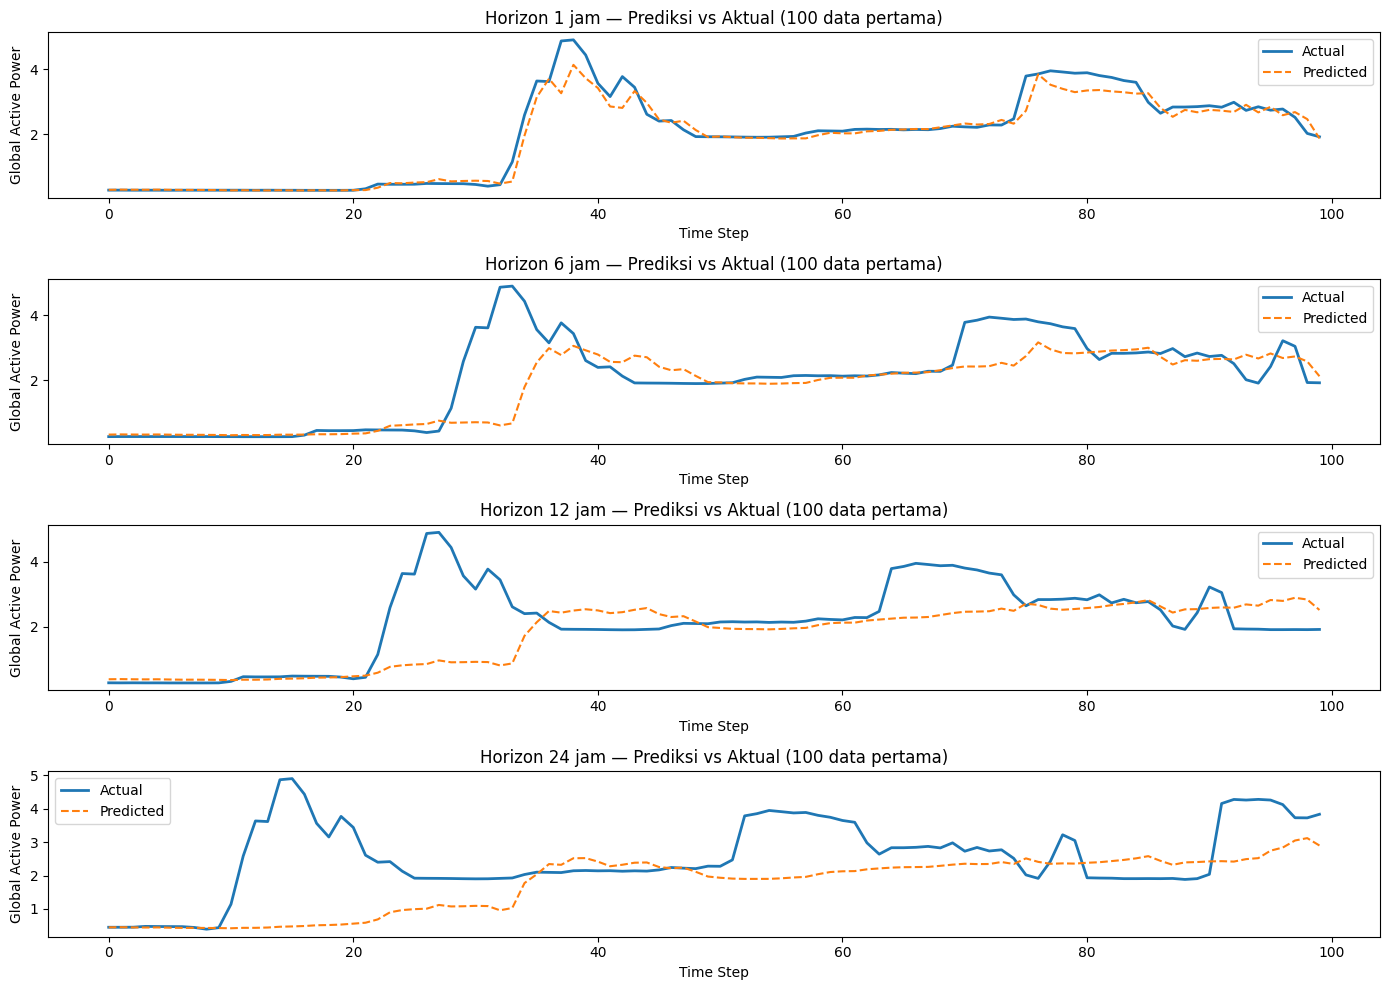

In [28]:
plt.figure(figsize=(14, 10))

# Loop untuk tiap horizon
for i, step in enumerate(horizon_steps):
    plt.subplot(len(horizon_steps), 1, i+1)  # buat subplot tiap horizon
    plt.plot(y_true_test[:100, i], label='Actual', linewidth=2)
    plt.plot(y_pred_test[:100, i], label='Predicted', linestyle='--')
    plt.title(f"Horizon {step} jam — Prediksi vs Aktual (100 data pertama)")
    plt.xlabel("Time Step")
    plt.ylabel("Global Active Power")
    plt.legend()

plt.tight_layout()
plt.show()

In [1]:
!pip install tensorflowjs

In [5]:
from tensorflow import keras
model = keras.models.load_model("/content/best_modelLSTM.keras")

# simpan ulang ke format .h5
model.save("/content/best_modelLSTM.h5")

In [6]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/best_modelLSTM.h5 \
    /content/energymate_tfjs

2025-10-16 05:22:33.401646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760592153.421698   27146 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760592153.429074   27146 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760592153.444551   27146 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760592153.444577   27146 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760592153.444582   27146 computation_placer.cc:177] computation placer alr

# Model GRU 48 Jam Terakhir

In [ ]:
# Sequences untuk multi-step forecasting
def create_multistep_sequences_gru(X, y, seq_length=48, horizon_steps=[1, 6, 12, 24]):
    Xs, ys = [], []
    for i in range(len(X) - seq_length - max(horizon_steps)):
        Xs.append(X[i:i+seq_length])
        ys.append([y[i+seq_length+h-1, 0] for h in horizon_steps])
    return np.array(Xs), np.array(ys)

# Sequence dengan 48 jam input
seq_length = 48
horizon_steps = [1, 6, 12, 24]

X_train_seq, y_train_seq = create_multistep_sequences_gru(X_train, y_train, seq_length, horizon_steps)
X_val_seq, y_val_seq = create_multistep_sequences_gru(X_val, y_val, seq_length, horizon_steps)
X_test_seq, y_test_seq = create_multistep_sequences_gru(X_test, y_test, seq_length, horizon_steps)

print(f"Train shape: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"Val shape: {X_val_seq.shape}, {y_val_seq.shape}")
print(f"Test shape: {X_test_seq.shape}, {y_test_seq.shape}")

Train shape: (1311071, 48, 5), (1311071, 4)
Val shape: (327714, 48, 5), (327714, 4)
Test shape: (409661, 48, 5), (409661, 4)


In [ ]:
model_gru = Sequential([
    GRU(64, input_shape=(seq_length, X.shape[1]), return_sequences=True),
    Dropout(0.3),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(4) # output 4 horizon (1h, 6h, 12h, 24h)
])

model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callback
checkpoint = ModelCheckpoint("best_modelGRU.keras", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model_gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=15,
    batch_size=128,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 100s 10ms/step - loss: 0.0033 - mae: 0.0323 - val_loss: 0.0025 - val_mae: 0.0279
Epoch 2/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - loss: 0.0029 - mae: 0.0294 - val_loss: 0.0024 - val_mae: 0.0270
Epoch 3/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - loss: 0.0028 - mae: 0.0289 - val_loss: 0.0024 - val_mae: 0.0268
Epoch 4/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - loss: 0.0027 - mae: 0.0285 - val_loss: 0.0022 - val_mae: 0.0259
Epoch 5/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - loss: 0.0026 - mae: 0.0280 - val_loss: 0.0022 - val_mae: 0.0259
Epoch 6/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - loss: 0.0026 - mae: 0.0276 - val_loss: 0.0022 - val_mae: 0.0250
Epoch 7/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - loss: 0.0025 - mae: 0.0274 - val_loss: 0.0021 - val_mae: 0.0245
Epoch 8/15
10243/10243 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - loss: 0.0025 - mae: 0.0271 - val_loss: 0.0021 - val_mae: 0.0244
Epoch 9

In [ ]:
def evaluate_model(name, X_seq, y_seq, scaler_y, model, horizon_steps):
    y_pred = model_gru.predict(X_seq)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_true_rescaled = scaler_y.inverse_transform(y_seq)

    print(f"\n===== Evaluasi pada {name} set =====")
    for i, step in enumerate(horizon_steps):
        mae = mean_absolute_error(y_true_rescaled[:, i], y_pred_rescaled[:, i])
        rmse = np.sqrt(mean_squared_error(y_true_rescaled[:, i], y_pred_rescaled[:, i]))
        r2 = r2_score(y_true_rescaled[:, i], y_pred_rescaled[:, i])
        print(f"\n--- Horizon {step} jam ---")
        print(f"MAE  = {mae:.4f}")
        print(f"RMSE = {rmse:.4f}")
        print(f"R²   = {r2:.4f}")

# === Evaluasi untuk Train, Validation, dan Test ===
evaluate_model("Train", X_train_seq, y_train_seq, y_scaler, model_gru, horizon_steps)
evaluate_model("Test", X_test_seq, y_test_seq, y_scaler, model_gru, horizon_steps)


40971/40971 ━━━━━━━━━━━━━━━━━━━━ 117s 3ms/step

===== Evaluasi pada Train set =====

--- Horizon 1 jam ---
MAE  = 0.1113
RMSE = 0.2505
R²   = 0.9491

--- Horizon 6 jam ---
MAE  = 0.2440
RMSE = 0.4793
R²   = 0.8137

--- Horizon 12 jam ---
MAE  = 0.3142
RMSE = 0.5867
R²   = 0.7208

--- Horizon 24 jam ---
MAE  = 0.4045
RMSE = 0.6911
R²   = 0.6125
12802/12802 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step

===== Evaluasi pada Test set =====

--- Horizon 1 jam ---
MAE  = 0.0931
RMSE = 0.2027
R²   = 0.9467

--- Horizon 6 jam ---
MAE  = 0.2254
RMSE = 0.4167
R²   = 0.7748

--- Horizon 12 jam ---
MAE  = 0.2862
RMSE = 0.5124
R²   = 0.6595

--- Horizon 24 jam ---
MAE  = 0.3628
RMSE = 0.6057
R²   = 0.5241
